In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, ImproperUniform
)
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import Salpeter

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)

In [2]:
emulator = Emulator()

In [3]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [4]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

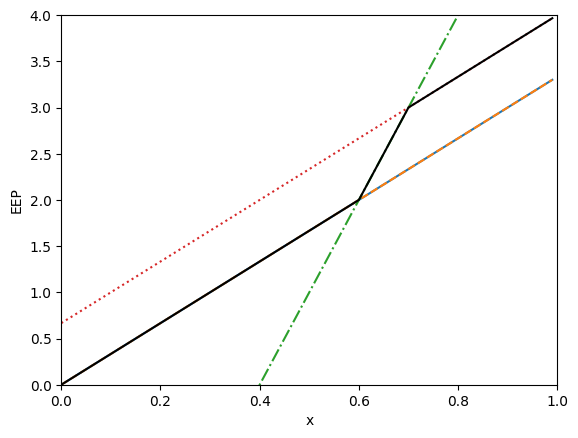

In [5]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [6]:
def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return jnp.log10(z / hydrogen(y, z)) - log_zx_sun

def heavy_elements(y, mh):
    return (1 - y) / (10**-(mh + log_zx_sun) + 1)

def model(lum=None, teff=None, mh=None, sigma_lum=0.01, sigma_teff=50.0, sigma_mh=0.05):
    x = numpyro.sample("x", Uniform(0.0, 0.999))
    eep = numpyro.deterministic("EEP", evol_phase(x))
    
    mass = numpyro.sample("mass", Salpeter(2.35, low=0.7, high=2.3))
    y = numpyro.sample("Y", Uniform(0.22, 0.32))
    
#     _mh = numpyro.sample("_M_H", Uniform(-0.94, 0.56))
#     z = numpyro.deterministic("Z", heavy_elements(y, _mh))
#     log_z = numpyro.deterministic("log_Z", jnp.log10(z))

    log_z = numpyro.sample("log_Z", Uniform(-2.8, -1.4))
    z = numpyro.deterministic("Z", 10**log_z)
    a_mlt = numpyro.sample("a_MLT", Uniform(1.3, 2.7))

#     a_mlt_scaled = numpyro.sample("a_MLT_scaled", Beta(1.2, 1.2))
#     a_mlt = numpyro.deterministic("a_MLT", 1.3 + 1.4*a_mlt_scaled)

    xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
    yy = emulator(xx)

    log_lum = log_luminosity(yy[1], yy[2])

    numpyro.sample("lum", Normal(10**log_lum, sigma_lum), obs=lum)
    numpyro.sample("Teff", Normal(10**yy[1], sigma_teff), obs=teff)
    numpyro.sample("M_H", TruncatedNormal(metallicity(y, z), sigma_mh, low=-0.9, high=0.5), obs=mh)
#     numpyro.sample("M_H", Normal(_mh, sigma_mh), obs=mh)

    log_age = numpyro.deterministic("log_age", yy[0])
    age = numpyro.deterministic("age", 10**log_age)

    # While this validate_args sets log_prob to -inf if outside bounds
    # This counts as a divergence. Not ideal! 
#     numpyro.factor("log_prob_age", Uniform(1e7, 14e9, validate_args=True).log_prob(age))

In [7]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior_samples = prior_predictive(key)

In [8]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

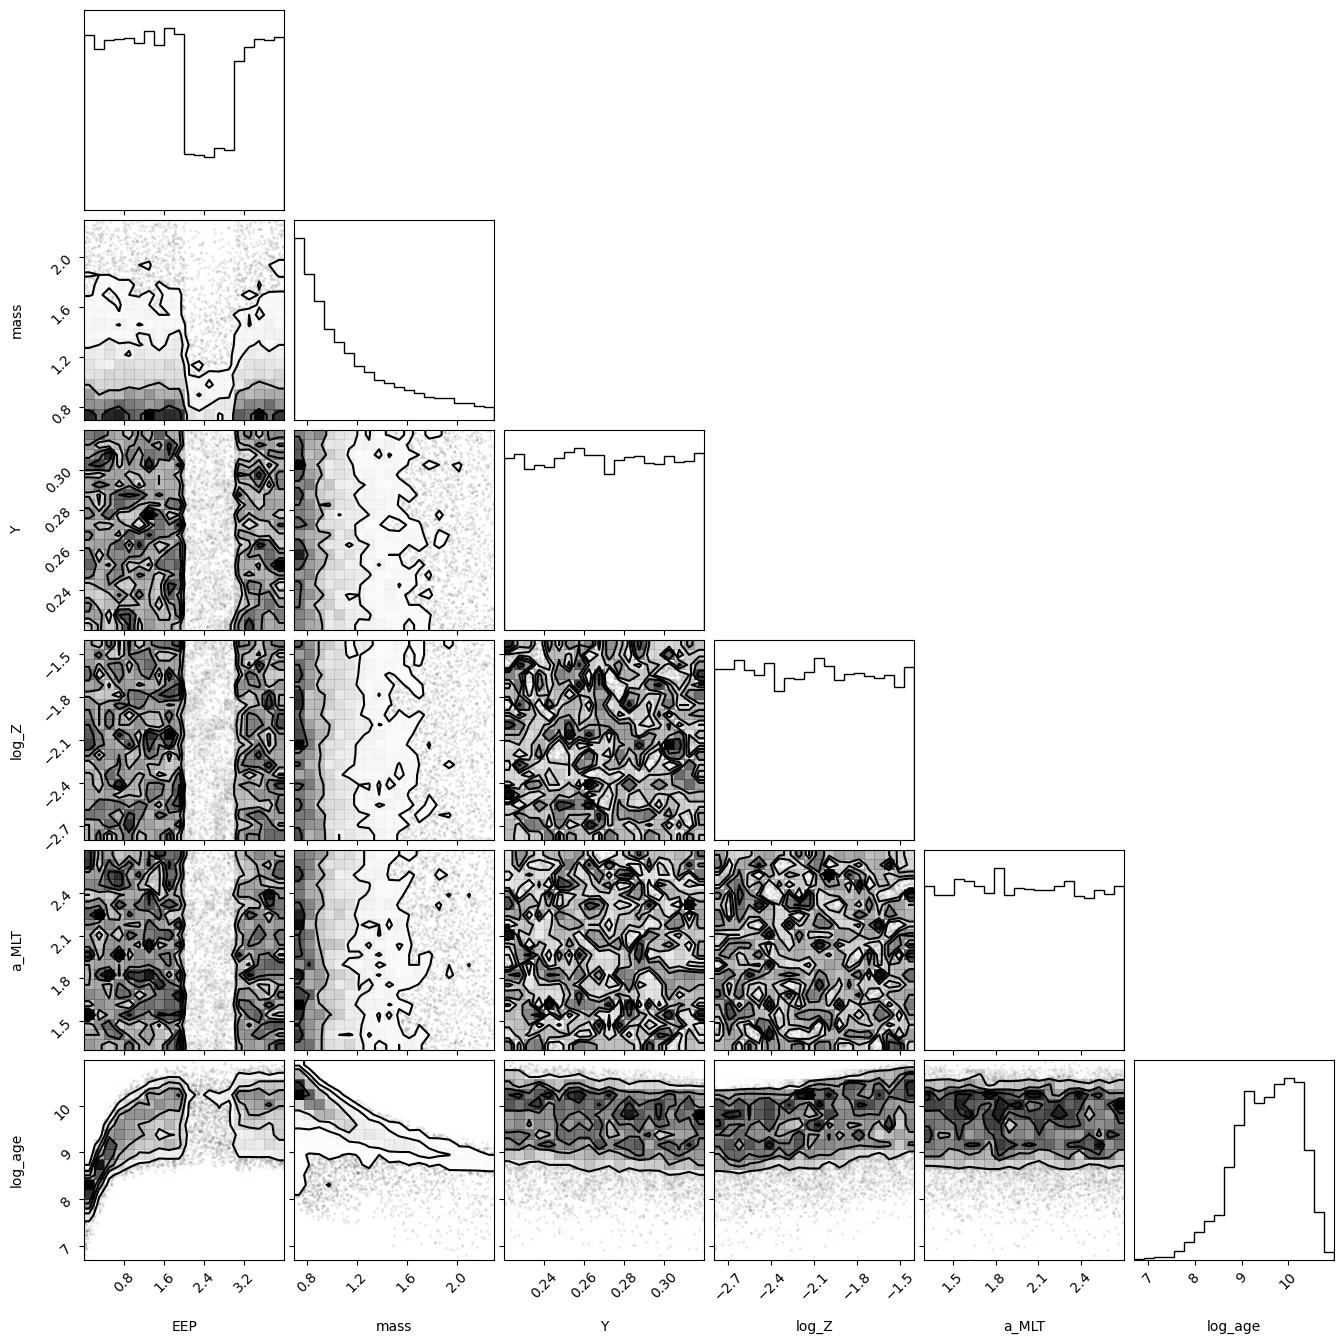

In [9]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "log_Z", "a_MLT", "log_age"])

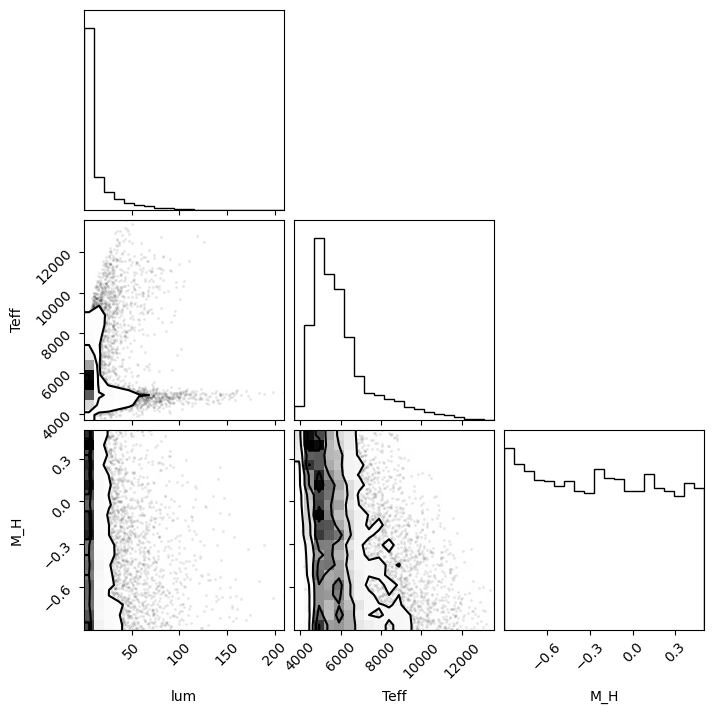

In [10]:
fig = corner(data, group="prior", var_names=["lum", "Teff", "M_H"])

In [11]:
lum, sigma_lum = 45.87, 0.9
teff, sigma_teff = 4998.0, 75.
mh, sigma_mh = -0.6, 0.1

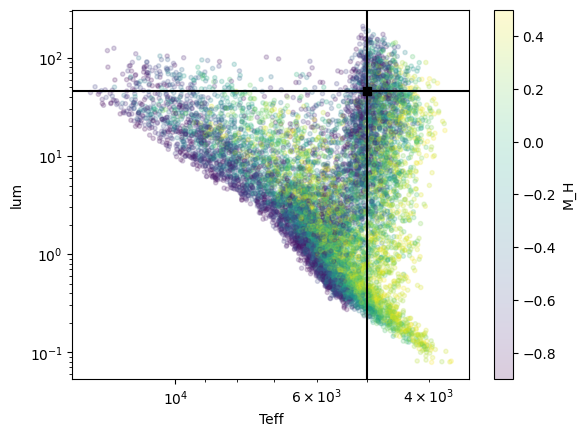

In [12]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "M_H"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

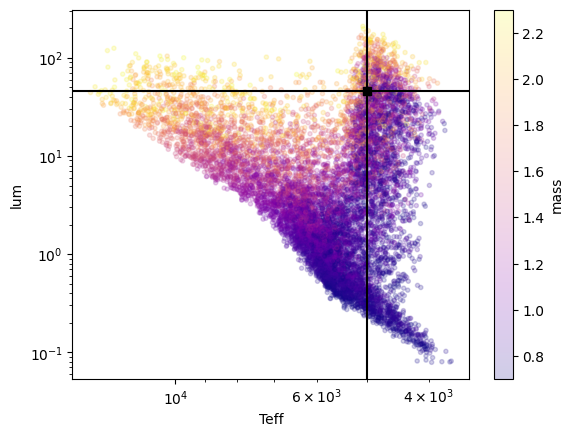

In [13]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

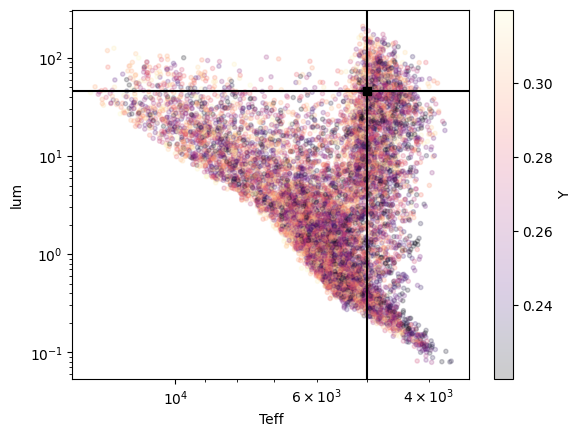

In [14]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

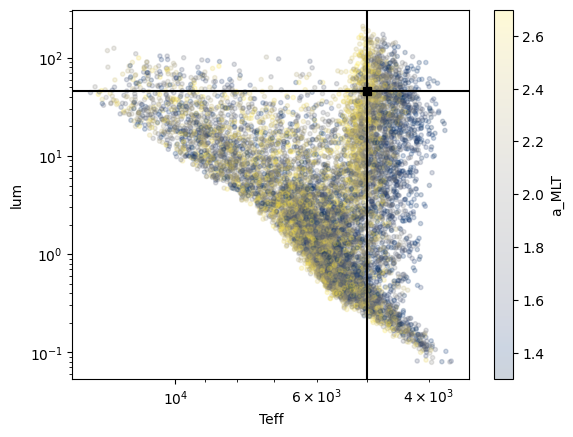

In [15]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

ax.axvline(teff, c="k")
# ax.axvline(teff+sigma_teff, c="k", ls=":")
# ax.axvline(teff-sigma_teff, c="k", ls=":")

ax.axhline(lum, c="k")
# ax.axhline(lum+sigma_lum, c="k", ls=":")
# ax.axhline(lum-sigma_lum, c="k", ls=":")
ax.plot(teff, lum, "ks");

In [16]:
nuts = NUTS(model, init_strategy=numpyro.infer.init_to_median,
#             dense_mass=[("log_Z", "a_MLT")],  # huge degenerecy between these
            dense_mass=True  # helps a lot
            )
mcmc = MCMC(nuts, num_warmup=3000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [17]:
rng, key = random.split(rng)
mcmc.run(key, lum=lum, teff=teff, mh=mh,
         sigma_lum=sigma_lum, sigma_teff=sigma_teff, sigma_mh=sigma_mh)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         Y      0.27      0.03      0.28      0.23      0.32    443.09      1.03
     a_MLT      2.21      0.31      2.25      1.76      2.70    108.80      1.07
     log_Z     -2.49      0.11     -2.49     -2.66     -2.31    427.58      1.02
      mass      1.20      0.39      1.09      0.70      1.82    102.23      1.08
         x      0.91      0.06      0.92      0.82      0.98    109.69      1.07

Number of divergences: 441


In [19]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [20]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key)

In [21]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

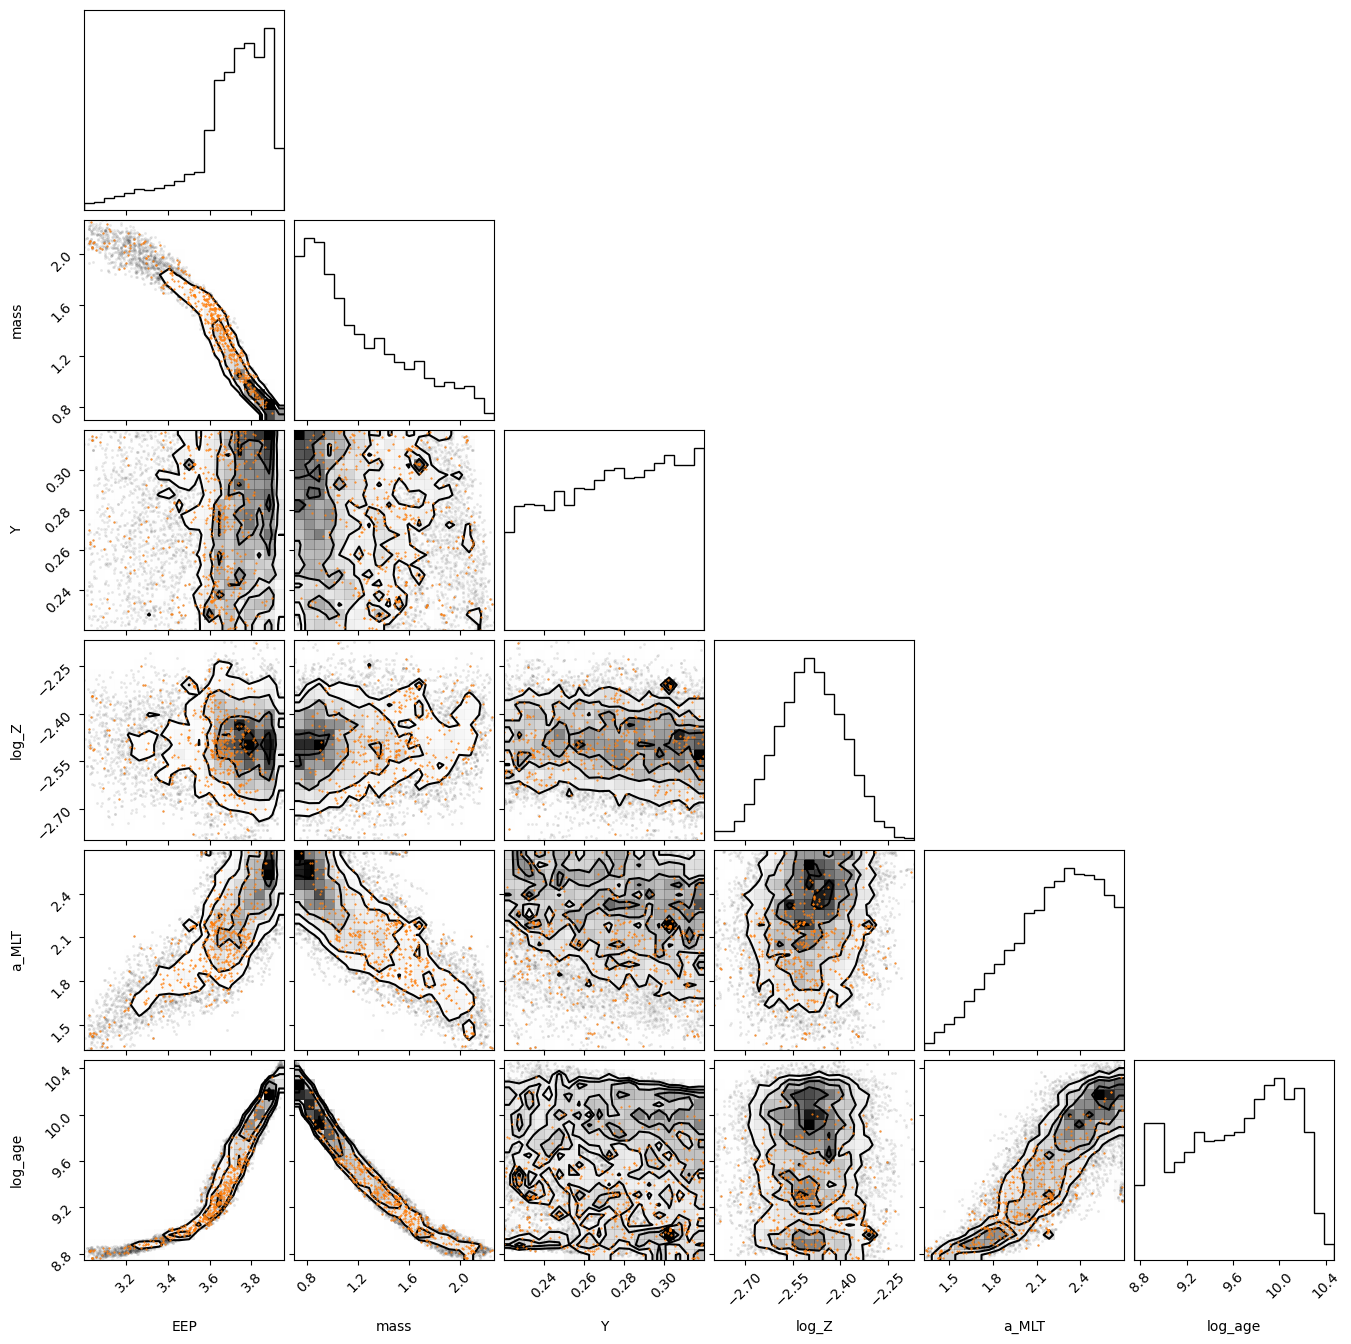

In [34]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "log_Z", 
    "a_MLT", 
    "log_age",
]
fig = corner(
    data, 
    var_names=var_names, 
    divergences=True
)

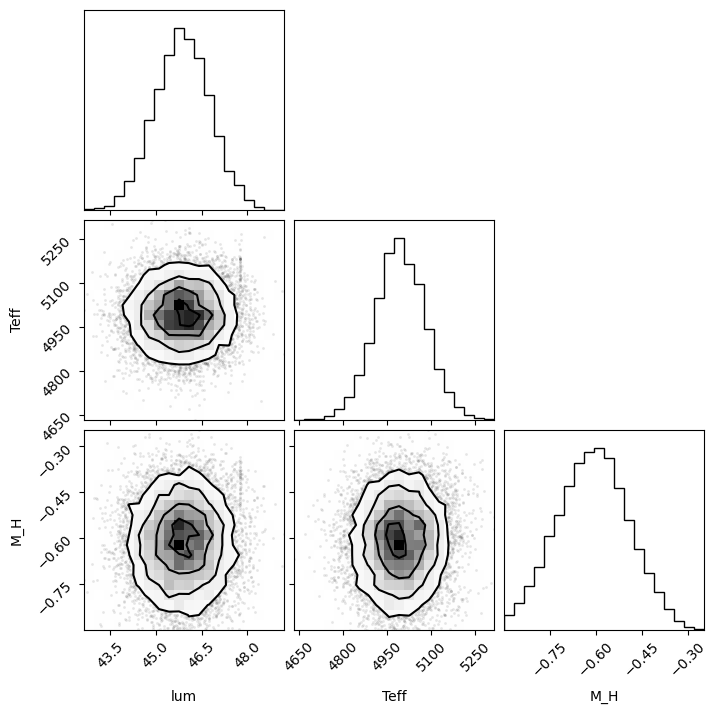

In [23]:
fig = corner(data, group="posterior_predictive", var_names=["lum", "Teff", "M_H"])